# Attempt to measure an artifact kernel
## From background pixels

M. Gully-Santiago  
July 2019
Kepler/K2 GO Office


In [1]:
import numpy as np
from astropy.io import fits
import copy
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.timeseries import LombScargle

In [2]:
import scope
import lightkurve as lk
import everest

Let's turn off `DEBUG` logging messages.

In [3]:
import logging 
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING) 
bok_log = logging.getLogger('bokeh') 
bok_log.setLevel(logging.WARNING) 
logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)

# What does the background look like in a PSD?

First let's get nearby star background pixels.

In [4]:
search_result = lk.search_targetpixelfile('OJ 287', mission='K2', cadence='long', campaign=5, radius=21*u.arcminute)

In [5]:
search_result

SearchResult containing 87 data products.

 target_name           productFilename                        description                   distance     
------------- ---------------------------------- ------------------------------------- ------------------
ktwo211991001 ktwo211991001-c05_lpd-targ.fits.gz Target Pixel Long Cadence (KTL) - C05                0.0
ktwo211989121 ktwo211989121-c05_lpd-targ.fits.gz Target Pixel Long Cadence (KTL) - C05 112.45681931867284
ktwo211987018 ktwo211987018-c05_lpd-targ.fits.gz Target Pixel Long Cadence (KTL) - C05 230.28634265106294
ktwo211989466 ktwo211989466-c05_lpd-targ.fits.gz Target Pixel Long Cadence (KTL) - C05 268.06611859515004
ktwo211985278 ktwo211985278-c05_lpd-targ.fits.gz Target Pixel Long Cadence (KTL) - C05  330.4400417001674
ktwo211986360 ktwo211986360-c05_lpd-targ.fits.gz Target Pixel Long Cadence (KTL) - C05  340.1449072088741
ktwo211990988 ktwo211990988-c05_lpd-targ.fits.gz Target Pixel Long Cadence (KTL) - C05  346.4351223021138
ktw

In [6]:
tpfs = search_result.download_all()

## Data pre-processing

#### Make sure all tpfs share the same cadence quality mask.

In [7]:
all_cadence_set = set(tpfs[0].cadenceno)

for tpf in tpfs:
    all_cadence_set.intersection_update(set(tpf.cadenceno))

cad_array = np.array(list(all_cadence_set))

In [8]:
tpf = tpfs[0]
tpf = tpf[np.in1d(tpf.cadenceno, cad_array)]

In [9]:
len(tpf.time)

3446

In [10]:
lc = tpf.to_lightcurve()

#### What do do about non-uniform time sampling?

Nothing for now!  You could fill the gaps if you want.

In [11]:
t_gaps = ((lc.time[1:] - lc.time[0:-1])*u.day).to(u.hour)

In [12]:
np.max(t_gaps)

<Quantity 1.96146661 h>

The largest gap is four consecutive 30-minute cadences.

In [13]:
t = (lc.time*u.day).to(u.second).value
NN = len(lc.time)

## Compute the power spectrum for each empty pixel
...and explore the range of values.

In [14]:
fake_omega = np.logspace(-6, -4, base=10)
fake_pow = fake_omega**(-2) *1e5

In [15]:
f = np.fft.rfftfreq(len(t), t[1] - t[0])

In [16]:
def bkg_flux_model(t, y, y_unc, poly_order=2):
    '''Makes a polynomial model of the already-subtracted background'''
    A = np.vander(t, 1+poly_order)
    ATA = np.dot(A.T, A / y_unc[:, None]**2)
    #sigma_w = np.linalg.inv(ATA)
    mean_w = np.linalg.solve(ATA, np.dot(A.T, y/y_unc**2))
    return np.dot(A, mean_w)

In [17]:
# Compute the LS based power spectrum estimates
power_ls = []
power_white_noise = []
power_bkg = []
for tpf in tpfs:
    tpf = tpf[np.in1d(tpf.cadenceno, cad_array)]
    background_mask = ~tpf.create_threshold_mask(threshold=0.001, reference_pixel=None)
    ncad, nx, ny = tpf.flux.shape
    y_vector = tpf.flux.reshape(ncad, nx*ny)[:, background_mask.reshape(nx*ny)]
    noise_vector = tpf.flux_err.reshape(ncad, nx*ny)[:, background_mask.reshape(nx*ny)]
    bkg_vector = tpf.flux_bkg.reshape(ncad, nx*ny)[:, background_mask.reshape(nx*ny)]
    i=0
    for pixel_lc in y_vector.T:
        model = LombScargle(t, pixel_lc)
        power_ls.append(model.power(f[1:-1], method="fast", normalization="psd"))
    for noise_amp in noise_vector.T:
        y0 = np.random.normal(loc=np.zeros(len(noise_amp)), scale=noise_amp)
        model = LombScargle(t, y0)
        power_white_noise.append(model.power(f[1:-1], method="fast", normalization="psd"))
    for pixel_bkg in bkg_vector.T:
        y_hat = bkg_flux_model(t, pixel_bkg, pixel_bkg/100.0, poly_order=3)
        model = LombScargle(t, pixel_bkg-y_hat)
        power_bkg.append(model.power(f[1:-1], method="fast", normalization="psd"))
power_ls = np.array(power_ls)
power_white_noise = np.array(power_white_noise)
power_bkg = np.array(power_bkg)

# >>> To get the LS based PSD in the correct units, normalize by N <<<
power_ls /= NN
power_white_noise /= NN
power_bkg /= NN

The AGN target of interest.

In [18]:
tpf = tpfs[0]
tpf = tpf[np.in1d(tpf.cadenceno, cad_array)]

In [19]:
aperture_mask = tpf.create_threshold_mask()

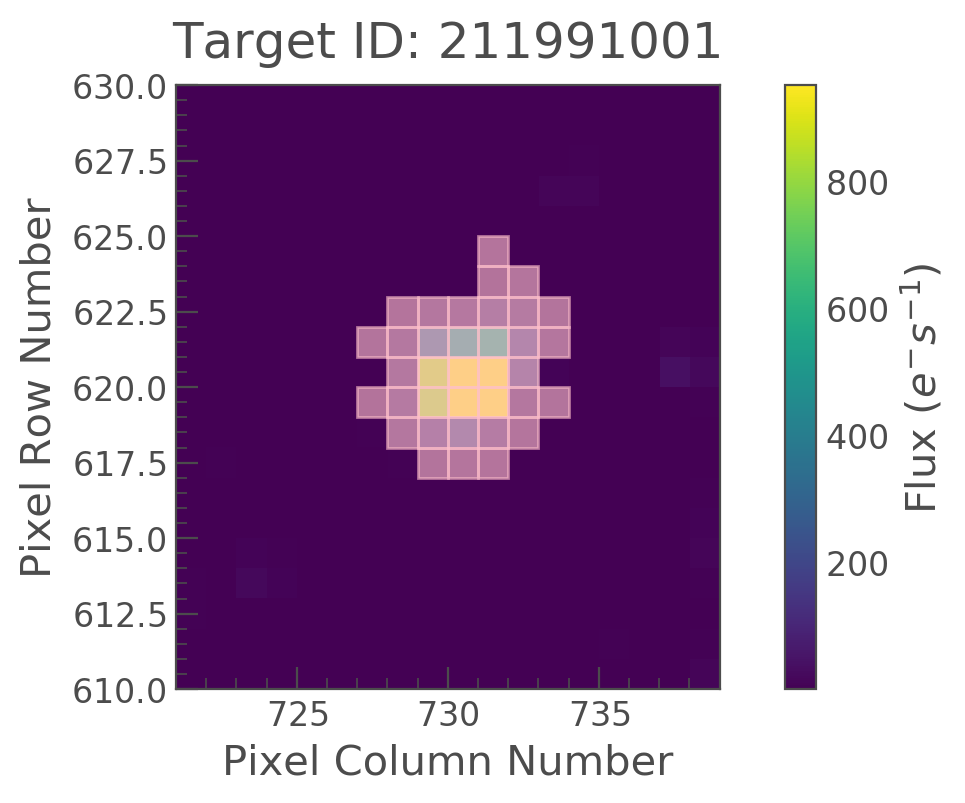

In [20]:
tpf.plot(aperture_mask=aperture_mask);

In [21]:
lc = tpf.to_lightcurve(aperture_mask=aperture_mask)

In [22]:
n_pix = aperture_mask.sum()
n_pix

36

In [23]:
model = LombScargle(t, lc.flux/n_pix)
power_AGN = model.power(f[1:-1], method="fast", normalization="psd") / NN

In [24]:
bkg_flux = np.sum(tpf.flux_bkg[:, aperture_mask ], axis=1)
bkg_flux_err = np.sqrt(np.sum(tpf.flux_bkg_err[:, aperture_mask ]**2, axis=1))

(0, 780.4116165161133)

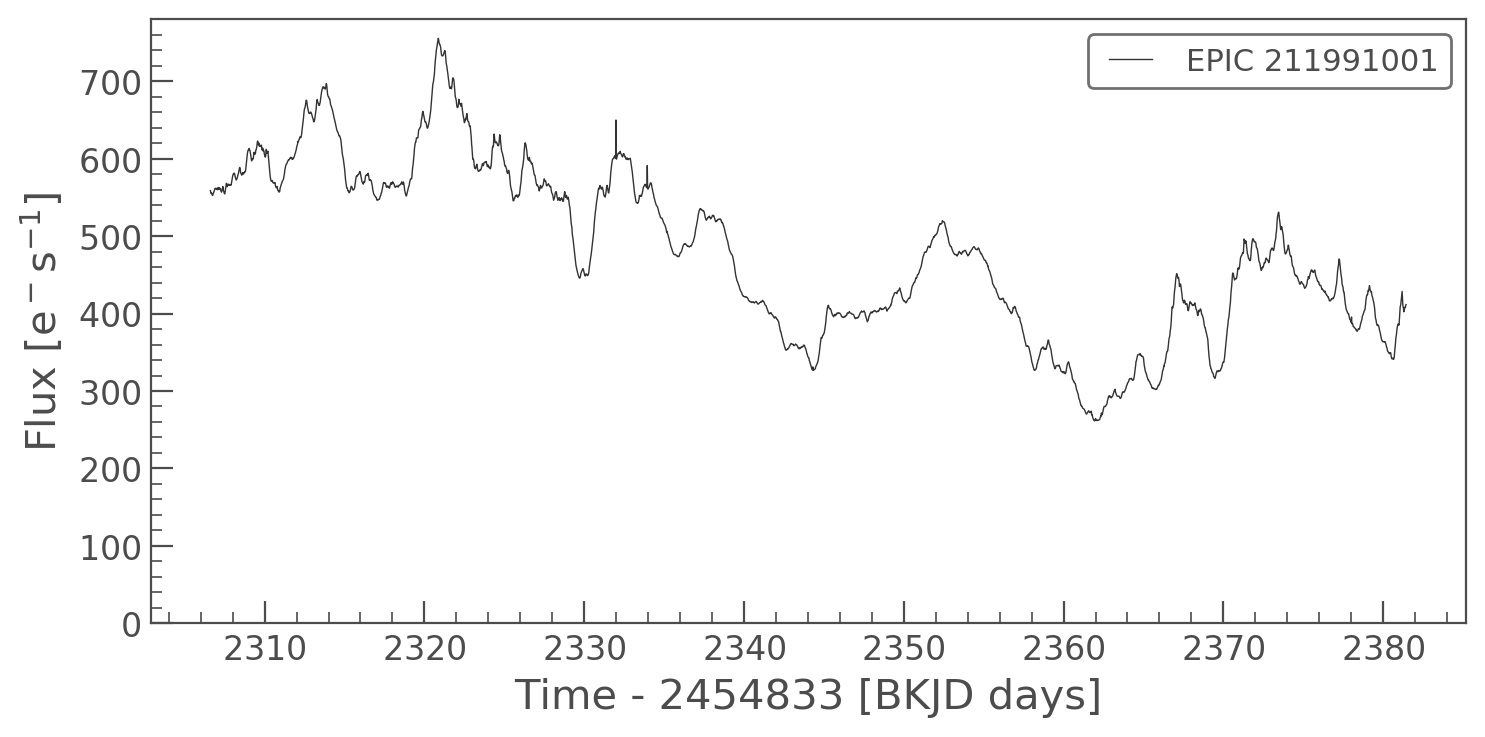

In [25]:
ax = (lc/n_pix).plot(normalize=False)
plt.ylim(0)

In [26]:
t_motion = (6.0*u.hour).to(u.second)

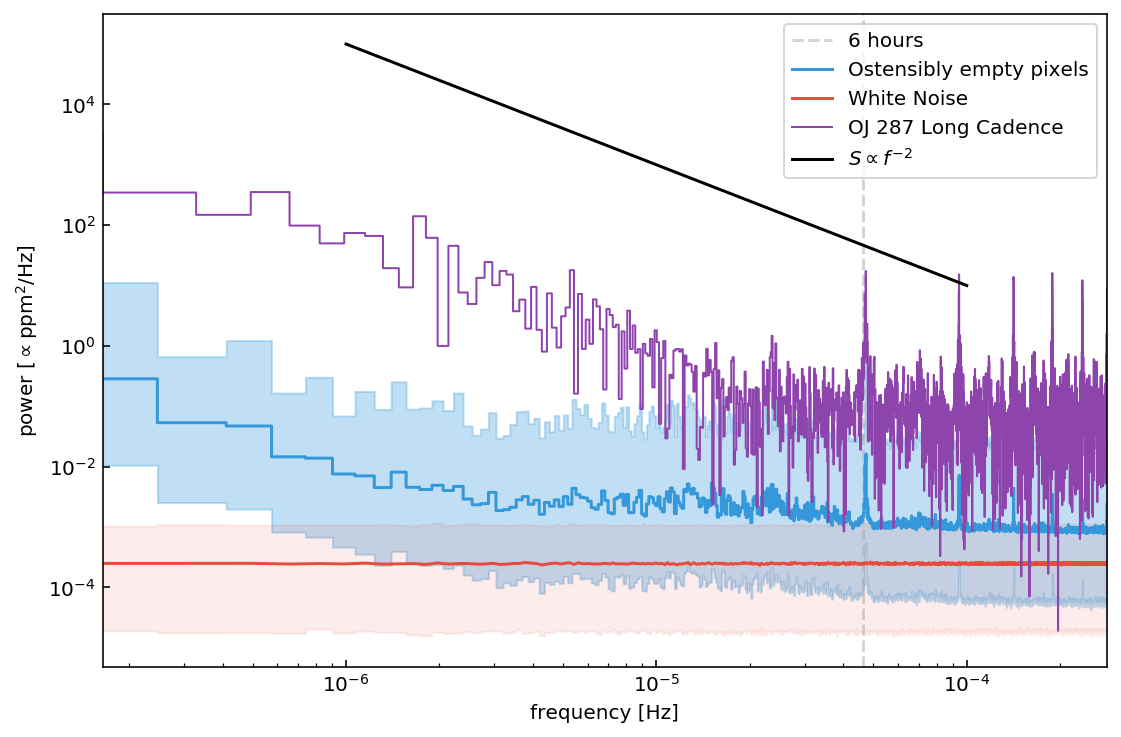

In [27]:
plt.figure(figsize=(9,6))
plt.axvline(1.0/t_motion.value, color='#aaaaaa', linestyle='dashed', label='6 hours', alpha=0.5)
percentile = 50

#plt.step(f[1:-1], np.nanpercentile(power_bkg,percentile, axis=0), "-", label="Background Estimate", color='#2ecc71')

plt.step(f[1:-1], np.nanpercentile(power_ls,percentile, axis=0), label="Ostensibly empty pixels", color='#3498db', where='mid')
plt.fill_between(f[1:-1], 
                 np.nanpercentile(power_ls,5, axis=0),
                 np.nanpercentile(power_ls,95, axis=0),
                 label=None, color='#3498db', alpha=0.3, step='mid')

plt.plot(f[1:-1], np.nanpercentile(power_white_noise,percentile, axis=0), "-", label="White Noise", color='#e74c3c')
plt.fill_between(f[1:-1], 
                 np.nanpercentile(power_white_noise,5, axis=0),
                 np.nanpercentile(power_white_noise,95, axis=0),
                 label=None, color='#e74c3c', alpha=0.1, step='mid')

plt.step(f[1:-1], power_AGN, label="OJ 287 Long Cadence", color='#8e44ad', lw=1)

plt.yscale("log")
plt.xscale("log")
plt.xlim(f[1:].min(), f.max())
plt.ylabel("power [$\propto \mathrm{ppm}^2/\mathrm{Hz}$]")
plt.xlabel("frequency [Hz]")

plt.plot(fake_omega, fake_pow/np.min(fake_pow)*10, 'k-', label='$S \propto f^{-2}$')

plt.legend(loc='best')
plt.savefig('OJ287_C05_PSD_v_empty_pixels.png', dpi=300, bbox_inches='tight');

## Model the PSD with a Damped Random Walk

In [28]:
t_char = (0.3*u.year).to(u.second)

In [29]:
c_val = 2.0*np.pi * 1/(t_char)

In [30]:
c_val.to(u.Hz) # units of Hertz

<Quantity 6.63673759e-07 Hz>

What about the value of $a$?  It should have units of $(\mathrm{dimensionless\; power}\cdot \mathrm{Hz})$, so it should be comparable to $c$ to achieve near-unity power.

In [31]:
a_val = c_val*5e6

In [32]:
a_val.to(u.Hz)

<Quantity 3.3183688 Hz>

We can use `celerite` to simulate the PSD.

In [33]:
from astropy.stats import LombScargle

import celerite
from celerite import terms

Note that celerité follows the numpy convention of **natural logs** $\ln{}$ for all $\log{}$ functions, unless explicitly providing base 10.

>Args:  
    - log_a (float): The log of the amplitude of the term.  
    - log_c (float): The log of the exponent of the term.

In [34]:
sigma = np.median(lc.flux_err)

In [35]:
true_logc, true_loga = np.log(c_val.value) , np.log(a_val.value)
kernel = terms.RealTerm(log_a=true_loga, log_c=true_logc) + terms.JitterTerm(log_sigma=np.log(sigma))
gp = celerite.GP(kernel, fit_mean=True, mean=0)
gp.compute(t)

In [36]:
y_many = gp.sample(size=1000)

In [37]:
power_draw = []
for y0 in y_many:
    model = LombScargle(t, y0)
    power_draw.append(model.power(f[1:-1], method="fast", normalization="psd"))
power_draw = np.array(power_draw)

# >>> To get the LS based PSD in the correct units, normalize by N <<<
power_draw /= NN

In [38]:
power_true = kernel.get_psd(2*np.pi*f) / (0.5 * (t[-1] - t[0]))

Let's plot the model in the time domain.

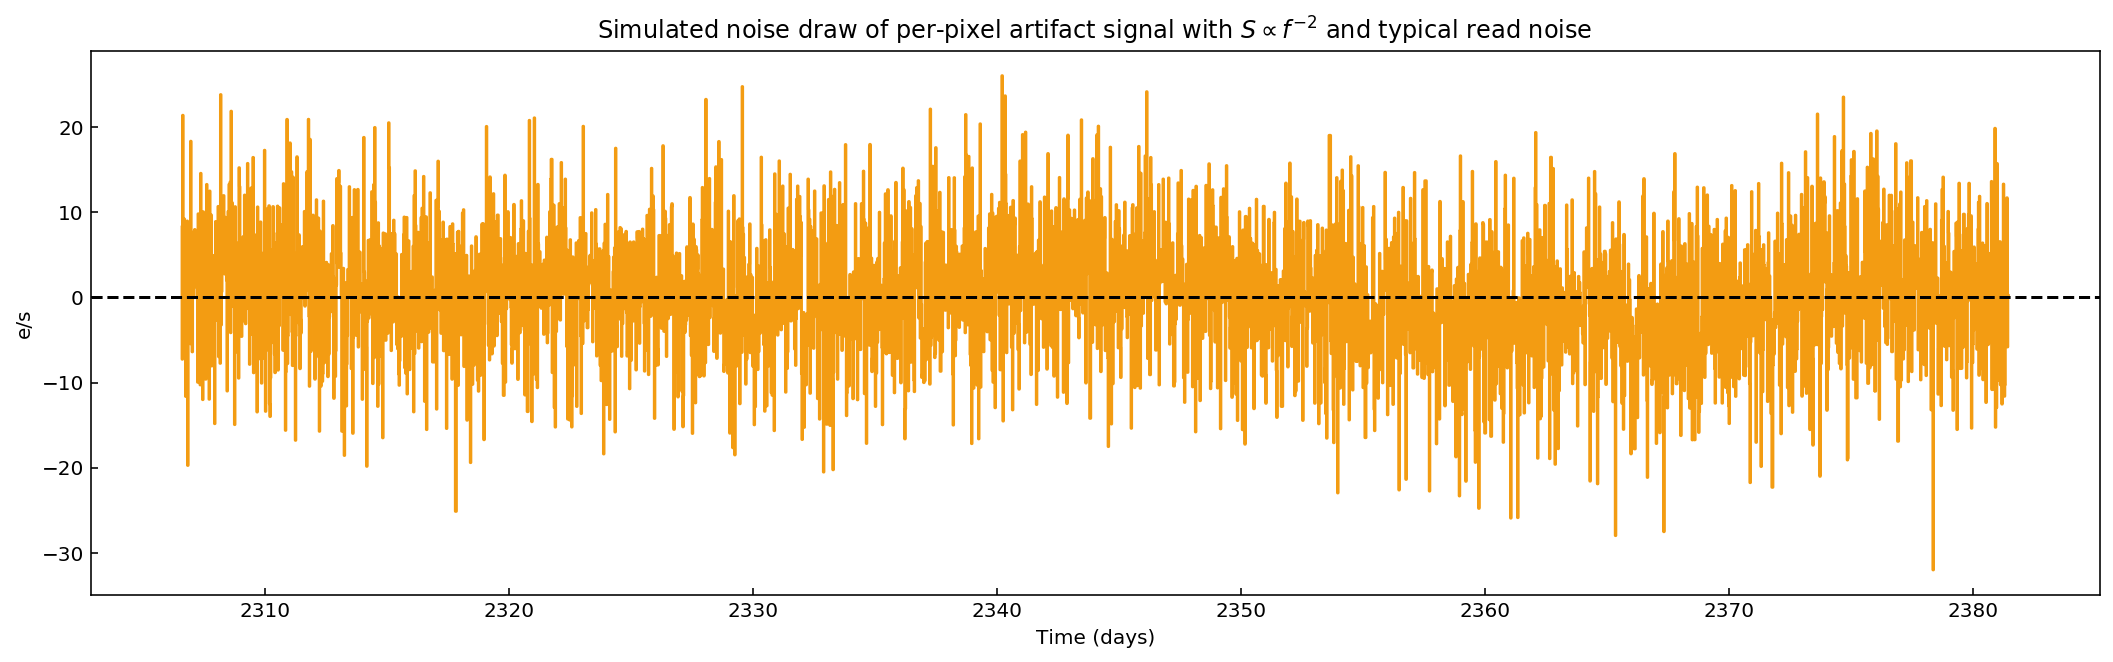

In [39]:
plt.figure(figsize=(18,5))
plt.step(lc.time, y_many[9,:],label='simulation', color='#f39c12')
plt.axhline(0, linestyle='dashed', color='k')
plt.title('Simulated noise draw of per-pixel artifact signal with $S \propto f^{-2}$ and typical read noise')
plt.ylabel('e/s')
plt.xlabel('Time (days)');

Indeed, the draw from the random walk process has more high-frequency structure than the genuine source.  The power law slope of OJ 287 is more negative than $-2$.

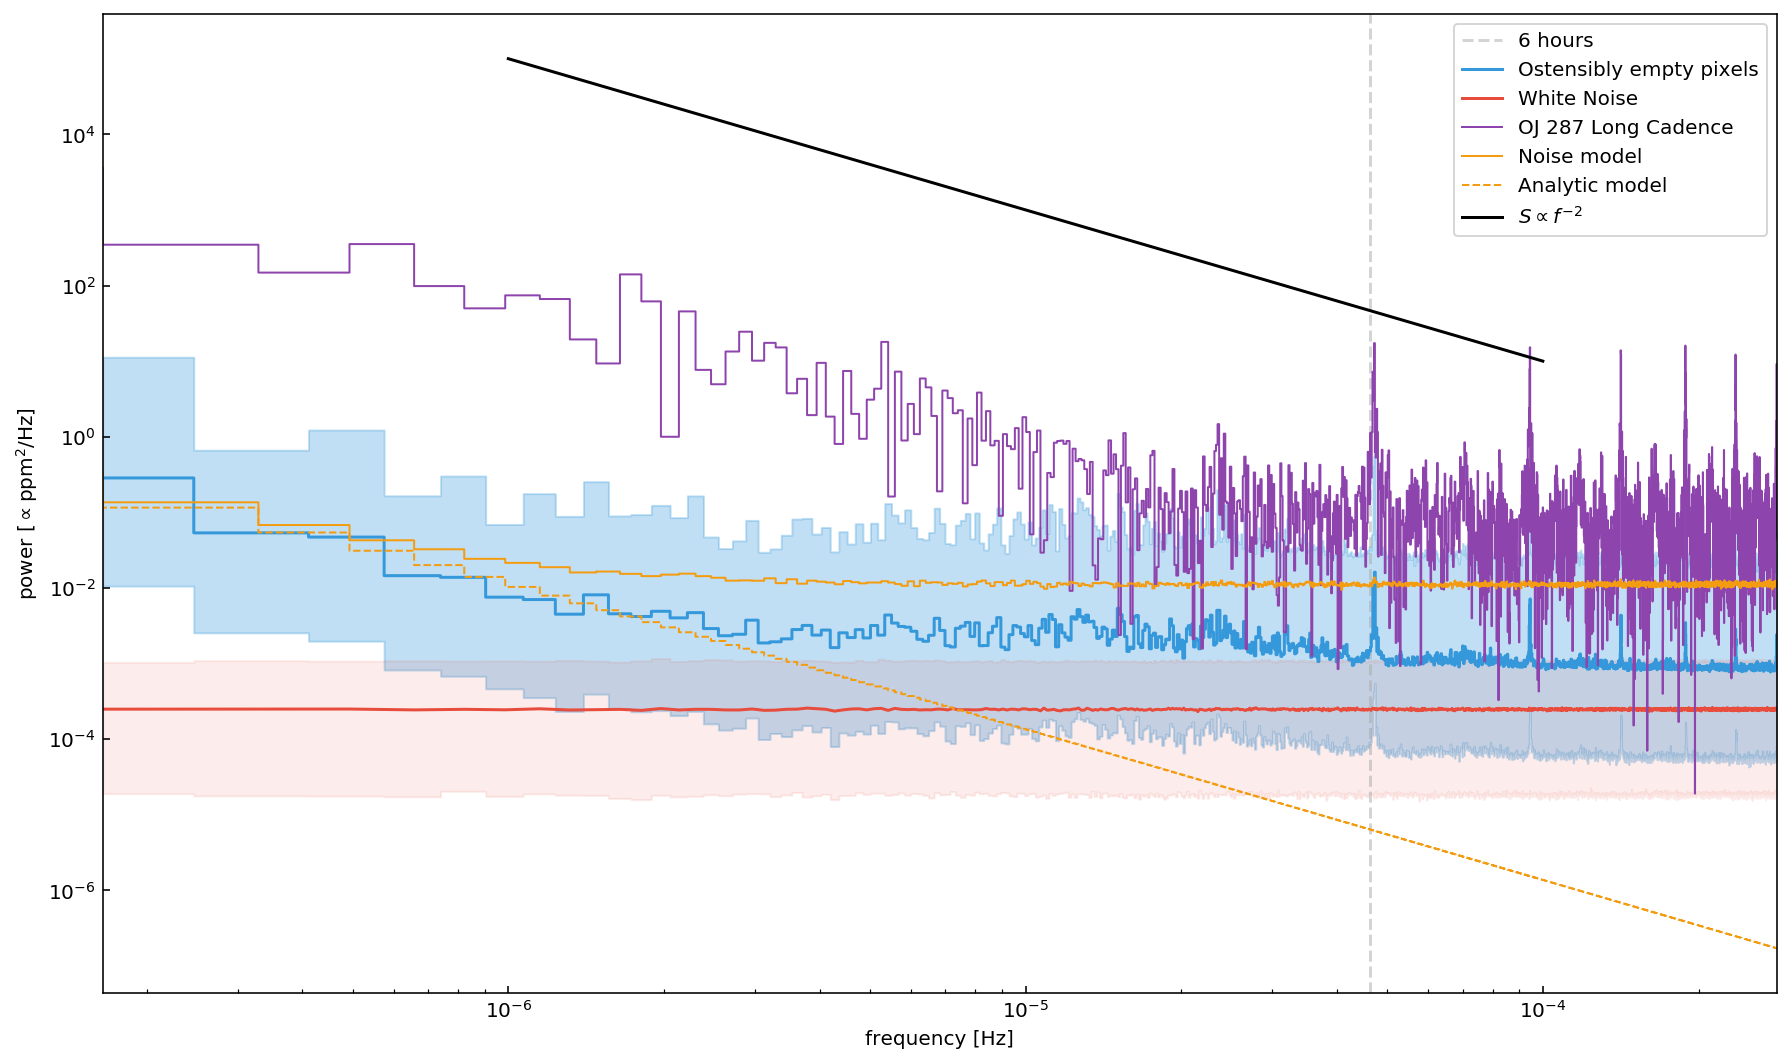

In [40]:
plt.figure(figsize=(15,9))
plt.axvline(1.0/t_motion.value, color='#aaaaaa', linestyle='dashed', label='6 hours', alpha=0.5)
percentile = 50

#plt.step(f[1:-1], np.nanpercentile(power_bkg,percentile, axis=0), "-", label="Background Estimate", color='#2ecc71')

plt.step(f[1:-1], np.nanpercentile(power_ls,percentile, axis=0), label="Ostensibly empty pixels", color='#3498db', where='mid')
plt.fill_between(f[1:-1], 
                 np.nanpercentile(power_ls,5, axis=0),
                 np.nanpercentile(power_ls,95, axis=0),
                 label=None, color='#3498db', alpha=0.3, step='mid')

plt.plot(f[1:-1], np.nanpercentile(power_white_noise,percentile, axis=0), "-", label="White Noise", color='#e74c3c')
plt.fill_between(f[1:-1], 
                 np.nanpercentile(power_white_noise,5, axis=0),
                 np.nanpercentile(power_white_noise,95, axis=0),
                 label=None, color='#e74c3c', alpha=0.1, step='mid')

plt.step(f[1:-1], power_AGN, label="OJ 287 Long Cadence", color='#8e44ad', lw=1)


plt.step(f[1:-1], np.nanmedian(power_draw, axis=0), label="Noise model", color='#f39c12', lw=1)
plt.step(f, power_true, '--', color='#f39c12', lw=1,label="Analytic model", )


plt.yscale("log")
plt.xscale("log")
plt.xlim(f[1:].min(), f.max())
plt.ylabel("power [$\propto \mathrm{ppm}^2/\mathrm{Hz}$]")
plt.xlabel("frequency [Hz]")

plt.plot(fake_omega, fake_pow/np.min(fake_pow)*10, 'k-', label='$S \propto f^{-2}$')

plt.legend(loc='best')
plt.savefig('OJ287_C05_PSD_v_empty_model.png', dpi=300, bbox_inches='tight');

Neat!  So we could in-principle model the extra PSD power with an "artifact" kernel.  In this case, the artifact kernel amplitude is much less than the AGN science kernel.  In other cases, the sources have comparable amplitudes, confounding the signal of interest.